# Route Transfer Modeling

In this notebook we will be utilizing the Markov Chain bus transit model as developed by W. Klumpenhouwer to model route transfers between buses. The idea is to start with a transfer point, a stop that has more than one route crossing it. Given that you start on route A which shares a transfer point with route B, what's the likelihood that route A arrives at the transfer point before route B. Using the Markovian Bus model as outlined [here](https://prism.ucalgary.ca/handle/1880/106559) we'll attempt to model this scenario in the city of Calgary. Using
Route 2 (Mt. Pleasant / Killarney 17 Ave.) to transfer over to Route 13 (Mount Royal) at the transfer point stop: NB 8 ST SW @ 14 AV SW.

In [1]:
import sys
sys.path.append("/usr/src/")
from RouteModel.route import Model

In [2]:
db_file = "../thesis_data.db"
route_2_id = 156
route_13_id = 70
transfer_point_stop_id = 1252
early_boundary = 15 # Boundary for maximum early/lateness
late_boundary = 40

In [3]:
## Find distributions at transfer point
route_2_model = Model.from_db(db=db_file, route_id=route_2_id , config_id=1 , dmin=-early_boundary, dmax=late_boundary)
route_2_model.set_state_from_db(db_file)
route_2_model.make_lognormal_probabilities()
route_2_seq = None
for seq, stop in enumerate(route_2_model.stop_list):
    if stop.stop_id == transfer_point_stop_id:
        route_2_seq = seq
        break
    
route_2_dist = route_2_model.evolve_to_stop(route_2_seq) 

In [4]:
route_13_model = Model.from_db(db=db_file, route_id=route_13_id , config_id=1 , dmin=-early_boundary, dmax=late_boundary)
route_13_model.set_state_from_db(db_file)
route_13_model.make_lognormal_probabilities()
route_13_seq = None
for seq, stop in enumerate(route_13_model.stop_list):
    if stop.stop_id == transfer_point_stop_id:
        route_13_seq = seq
        break
route_13_dist = route_13_model.evolve_to_stop(route_13_seq)

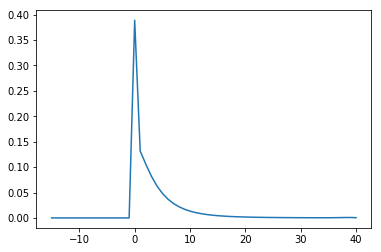

In [5]:
## Sanity check: plot the distributions.
import matplotlib.pyplot as plt
import numpy as np
t = np.arange(route_2_dist.shape[0]) - early_boundary
plt.plot(t,route_2_dist);

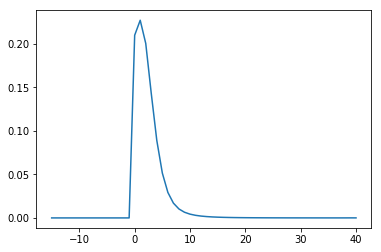

In [6]:
t = np.arange(route_13_dist.shape[0]) - early_boundary
plt.plot(t,route_13_dist);

In [7]:
## Get the distribution of co-ocurrences between arriving early/late between the two routes.
event_dist = np.outer(route_2_dist, route_13_dist)
# Helper function to get the probability
def P(t1, t2, event_dist):
    reshift_and_bound = lambda x: max(min(event_dist.shape[0],x+early_boundary),0)
    new_t1 = reshift_and_bound(t1)
    new_t2 = reshift_and_bound(t2)
    return event_dist[new_t1,new_t2]
    

Copied from the Calgary Transit website.

 ![](route_2_schedule.png)

 ![](route_13_schedule.png)

Looking at the schedule above, there are a couple different scenarios that one could take to transfer from Route 2 to Route 13. In terms of scheduling offset between the arrivals of the buses they are: 9 minutes, 19 minutes, 1 minute, 6 minutes. Depending on how early/late Route 2 is, route 13 can only then be so early/late minus the amount of scheduled offset. In order to calculate the total probability of according to each schedule we sum the probability of all the possible scenarios where you may make your connection.

In [8]:
## Probability of transfer according to offset
def p_transfer(schedule_offset, event_dist):
    total_probability = 0.0
    for t_route_2 in range(-early_boundary,late_boundary):
        for t_route_13 in range(t_route_2-schedule_offset, late_boundary):
            total_probability += P(t_route_2, t_route_13, event_dist)
    return total_probability
            
schedule_offsets = [9, 19, 1, 6]
probability_of_transfer = [p_transfer(offset, event_dist) for offset in schedule_offsets]

In [9]:
for offset,probability in zip(schedule_offsets,probability_of_transfer):
    print(f"Offset (mins): {offset} -- Probability {probability}")

Offset (mins): 9 -- Probability 0.9476553255297865
Offset (mins): 19 -- Probability 0.9882882855719716
Offset (mins): 1 -- Probability 0.6937164894133911
Offset (mins): 6 -- Probability 0.9044520181521101


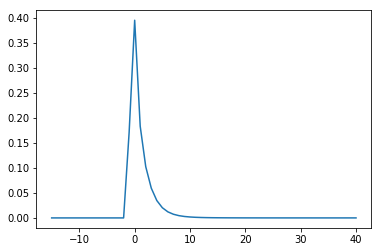

In [10]:
plt.plot(t,route_2_model.evolve_between_stops(route_2_seq-5,route_2_seq));

## Hub Modelling

Let's look to model a transit hub. We'll do this by first parsing the input json file to identify the routes that are linked to the Hub. Calculate the probabilities of making the transfer from route A to route B given a transfer time.

In [11]:
def setup_distribution(db:str, route_id:int, stop_seq:int, config_id:int, dmin:int, dmax:int) -> Model:
    model = Model.from_db(db, route_id, config_id, dmin, dmax)
    model.set_state_from_db(db)
    model.make_lognormal_probabilities()
    return model.evolve_to_stop(stop_seq)


In [12]:
import json
f = open('../utility/transfers.json','r')
data = json.loads(f.read())

In [13]:
data

{'network': 'Calgary Transit',
 'details': 'Data from October-December, 2015',
 'hubs': [{'name': 'University - Craigie Hall',
   'transfer_time': 1,
   'stops': [{'stop_code': 4402,
     'stop_id': 1756,
     'stop_lat': 51.076417,
     'stop_lon': -114.12861,
     'stop_name': 'WB University WY@ Craigie Hall'}],
   'routes': [{'route_id': 173,
     'stop_seq': 44,
     'nb': 2.0524105979441147,
     'na': 0.8240915013754162,
     'theta': 16.906326914724193,
     'route_number': 20,
     'route_name': '20 BRENTWOOD STN 20-20406-3'},
    {'route_id': 490,
     'stop_seq': 147,
     'nb': 0.7163323782234957,
     'na': 3.0250716332378222,
     'theta': 5.878462273161413,
     'route_number': 72,
     'route_name': '72 CIRCLE ROUTE 72-20406-2'},
    {'route_id': 740,
     'stop_seq': 21,
     'nb': 1.562374245472837,
     'na': 0.5543259557344065,
     'theta': 4.158953722334004,
     'route_number': 9,
     'route_name': '9 BRIDGELAND 9-20406-1'},
    {'route_id': 148,
     'stop_seq':

In [14]:
routes = {route['route_id']:setup_distribution(db=db_file, route_id=route['route_id'], stop_seq=route['stop_seq'], config_id=1, dmin=-early_boundary, dmax=late_boundary) for route in data['hubs'][0]['routes']}


In [15]:
def probability_of_transfer(route_A_id:int, route_B_id:int, transfer_time:int) -> float:
    event_dist = np.outer(routes[route_A_id], routes[route_B_id])
    return p_transfer(transfer_time, event_dist)

In [16]:
%time
probabilities = []
for id_a,_ in routes.items():
    for id_b,__ in routes.items():
        if id_a != id_b:
            p = probability_of_transfer(id_a, id_b, 5)
            print(f'{id_a}, {id_b}, {p}')
            probabilities.append(p)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs
173, 490, 0.8877021247848815
173, 740, 0.8465719651731541
173, 148, 0.8166129203320222
173, 175, 0.90130892266866
173, 512, 0.8370045119587258
490, 173, 0.5484542978729936
490, 740, 0.48233665414005855
490, 148, 0.44679907736811053
490, 175, 0.5786644433124871
490, 512, 0.4960519659185419
740, 173, 0.9960898076349809
740, 490, 0.9627951240591351
740, 148, 0.9973822564149617
740, 175, 0.9991517045811908
740, 512, 0.9940207077396365
148, 173, 0.9998093971335166
148, 490, 0.9805609371984744
148, 740, 0.9999999998398166
148, 175, 0.9999603124079273
148, 512, 0.9998897512225168
175, 173, 0.8455272800332737
175, 490, 0.8704305152474392
175, 740, 0.8064728779016244
175, 148, 0.7663393200037596
175, 512, 0.7975975204777449
512, 173, 0.9383303419098823
512, 490, 0.9318994173454539
512, 740, 0.9262334596507827
512, 148, 0.9101889300620072
512, 175, 0.9542776642459636


In [17]:
np.average(probabilities)

0.8506154736213241

In [18]:
probabilities

[0.8877021247848815,
 0.8465719651731541,
 0.8166129203320222,
 0.90130892266866,
 0.8370045119587258,
 0.5484542978729936,
 0.48233665414005855,
 0.44679907736811053,
 0.5786644433124871,
 0.4960519659185419,
 0.9960898076349809,
 0.9627951240591351,
 0.9973822564149617,
 0.9991517045811908,
 0.9940207077396365,
 0.9998093971335166,
 0.9805609371984744,
 0.9999999998398166,
 0.9999603124079273,
 0.9998897512225168,
 0.8455272800332737,
 0.8704305152474392,
 0.8064728779016244,
 0.7663393200037596,
 0.7975975204777449,
 0.9383303419098823,
 0.9318994173454539,
 0.9262334596507827,
 0.9101889300620072,
 0.9542776642459636]